# Neural network classification with PyTorch

Classifiction is a problem of predicting whether something is one thing or another (there can be multiple things as the options).



## 1. Make classifiction data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
# Make 1000 samples
n_samples = 1000
#Create  circles
X, y, = make_circles(n_samples, noise=0.03, random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of x: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of x: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:, 0], "X2":X[:, 1], "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


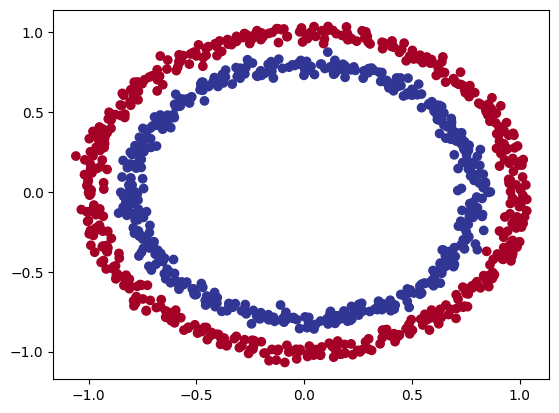

In [ ]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

**Note:** This dataset is often what's considered a **toy problem** (a problem that's used to try and test things out on) in machine learning.

But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

### 1.1 Check inout and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of featurs and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test split

In [ ]:
import torch
torch.__version__

'2.1.0+cu121'

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 0.2=20% of data will be test & 80% train

## 2. Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing nn.Module.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and `torch.nn` as well as setting up device agnostic code.

In [ ]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Create a model

1. Subclass `nn.Module`
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation)
4. Instatiate an instane of our model

In [ ]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 3 features and upsclaes 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features and uotput 1 feature (same shape as y)

  # 3. Define a forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x goes into layer 1 and output of layer 1 goes into layer 2 -> output

# 4. Instatiate an instance of our model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Replicate model above using nn.Sequential()
#model_0 = nn.Sequential(
#    nn.Linear(in_features=2, out_features=5),
#    nn.Linear(in_features=5, out_features=1)
#).to(device)

#model_0

In [ ]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2522,  0.4175],
                      [ 0.6193,  0.3467],
                      [-0.5816,  0.2294],
                      [-0.2073, -0.4611],
                      [-0.0293,  0.0505]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.4947,  0.3928, -0.6856, -0.0397, -0.4373], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.3113,  0.1924,  0.2539, -0.2491, -0.1862]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.1231], device='cuda:0'))])

In [ ]:
# make some predictions with the model
with torch.inference_mode():
  untrained_pred = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])


### 2.1 Setup loss function and optimizer

We've setup a loss (also called a criterion or cost function) and optimizer before in notebook 01.

But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, and the same applies to the Adam optimizer (torch.optim.Adam()).

In [ ]:
# Setup the loss function
#loss_fn = nn.BCELoss() # requres inputs to have the sigmoid activation function
loss_fn = nn.BCEWithLogitsLoss() # it has a sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 3. Training model

To train our model, we're going to need to build a training loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2295],
        [ 0.3713],
        [-0.1650],
        [ 0.3414],
        [-0.2013]], device='cuda:0')

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our `forward()` method.

Which implements two layers of nn.Linear() which internally calls the following equation: y=x weights + bias

The raw outputs (unmodified) of this equation (y) and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data (x in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

Let's try it out.

In [ ]:
# Use sigmoid on model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69815, Accuracy: 51.00% | Test loss: 0.70936, Test acc: 47.50%
Epoch: 10 | Loss: 0.69718, Accuracy: 51.12% | Test loss: 0.70729, Test acc: 47.00%
Epoch: 20 | Loss: 0.69648, Accuracy: 50.75% | Test loss: 0.70574, Test acc: 46.50%
Epoch: 30 | Loss: 0.69593, Accuracy: 50.88% | Test loss: 0.70450, Test acc: 47.00%
Epoch: 40 | Loss: 0.69550, Accuracy: 50.75% | Test loss: 0.70347, Test acc: 47.50%
Epoch: 50 | Loss: 0.69514, Accuracy: 50.75% | Test loss: 0.70260, Test acc: 48.00%
Epoch: 60 | Loss: 0.69485, Accuracy: 50.50% | Test loss: 0.70186, Test acc: 47.50%
Epoch: 70 | Loss: 0.69460, Accuracy: 50.62% | Test loss: 0.70121, Test acc: 47.50%
Epoch: 80 | Loss: 0.69439, Accuracy: 50.88% | Test loss: 0.70064, Test acc: 48.00%
Epoch: 90 | Loss: 0.69422, Accuracy: 51.00% | Test loss: 0.70014, Test acc: 48.00%


## 4. Make predictions and the model

from the matrics it looks like our model is not learning anything ...

Visualize

To do so, we are going to import a fucntion plot decision boundary

In [ ]:
import requests
from pathlib import Path

# Download helper functions from learn PyTorch repo
if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping download")
else:
  print("Download helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open ("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

Download helper_function.py


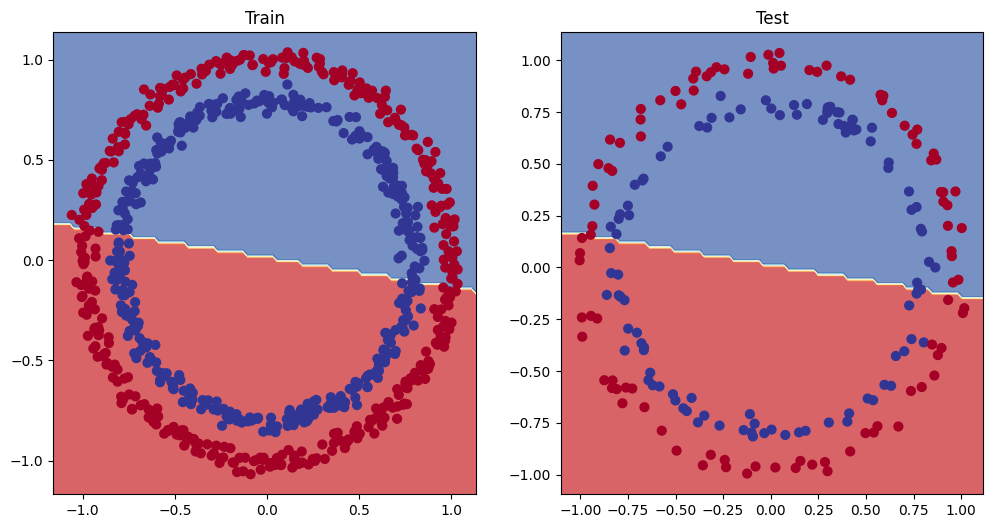

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data.
* Add more hidden units - go from 5 to 10 hidden units.
* Fit for longer.
* Changing the activation functions
* Change the learning rate.
* Change the loss function.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=10) # takes in 3 features and upsclaes 5 features
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1) # takes in 5 features and uotput 1 feature (same shape as y)

  # 3. Define a forward method
  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_1(z)
    #z = self.layer_1(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # x goes into layer 1 and output of layer 1 goes into layer 2 -> output

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
# write a training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_1(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


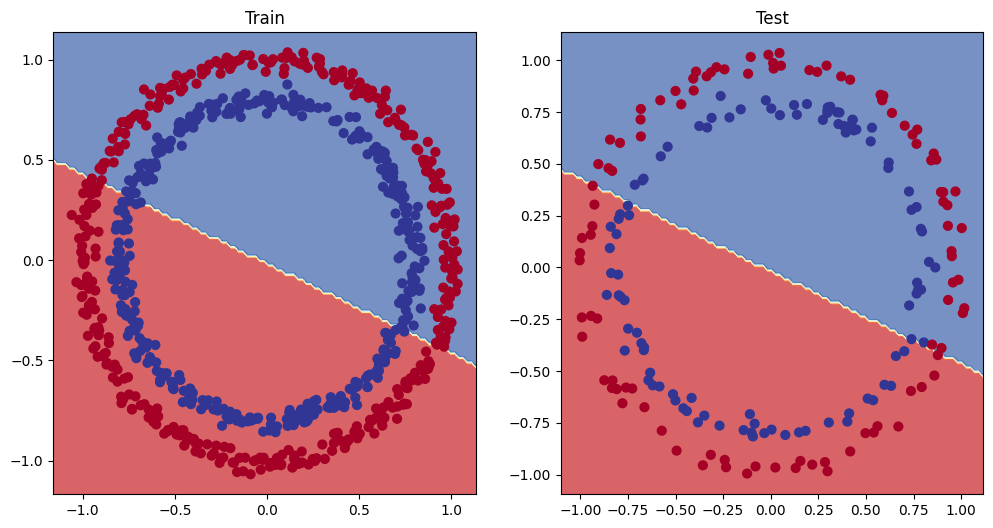

In [ ]:
# Plot decision boundary of the model_1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

In [ ]:
# Building a non-linear model
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=100) # takes in 3 features and upsclaes 5 features
    self.layer_2 = nn.Linear(in_features=100, out_features=100)
    self.layer_3 = nn.Linear(in_features=100, out_features=100) # takes in 5 features and uotput 1 feature (same shape as y)
    self.layer_4 = nn.Linear(in_features=100, out_features=1) # takes in 5 features and uotput 1 feature (same shape as y)
    self.relu = nn.ReLU()

  # 3. Define a forward method
  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_1(z)
    #z = self.layer_1(z)
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))) # x goes into layer 1 and output of layer 1 goes into layer 2 -> output

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=100, bias=True)
  (layer_4): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [ ]:
# write a training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_3(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69264, Accuracy: 55.12% | Test loss: 0.69329, Test acc: 50.50%
Epoch: 100 | Loss: 0.68457, Accuracy: 58.38% | Test loss: 0.68806, Test acc: 55.50%
Epoch: 200 | Loss: 0.66831, Accuracy: 62.62% | Test loss: 0.67507, Test acc: 57.50%
Epoch: 300 | Loss: 0.59866, Accuracy: 96.62% | Test loss: 0.61130, Test acc: 91.50%
Epoch: 400 | Loss: 0.47906, Accuracy: 62.88% | Test loss: 0.50650, Test acc: 62.00%
Epoch: 500 | Loss: 0.33327, Accuracy: 83.12% | Test loss: 0.39437, Test acc: 76.50%
Epoch: 600 | Loss: 0.04644, Accuracy: 100.00% | Test loss: 0.07117, Test acc: 100.00%
Epoch: 700 | Loss: 0.02048, Accuracy: 100.00% | Test loss: 0.03782, Test acc: 100.00%
Epoch: 800 | Loss: 0.01246, Accuracy: 100.00% | Test loss: 0.02631, Test acc: 100.00%
Epoch: 900 | Loss: 0.00876, Accuracy: 100.00% | Test loss: 0.02057, Test acc: 100.00%


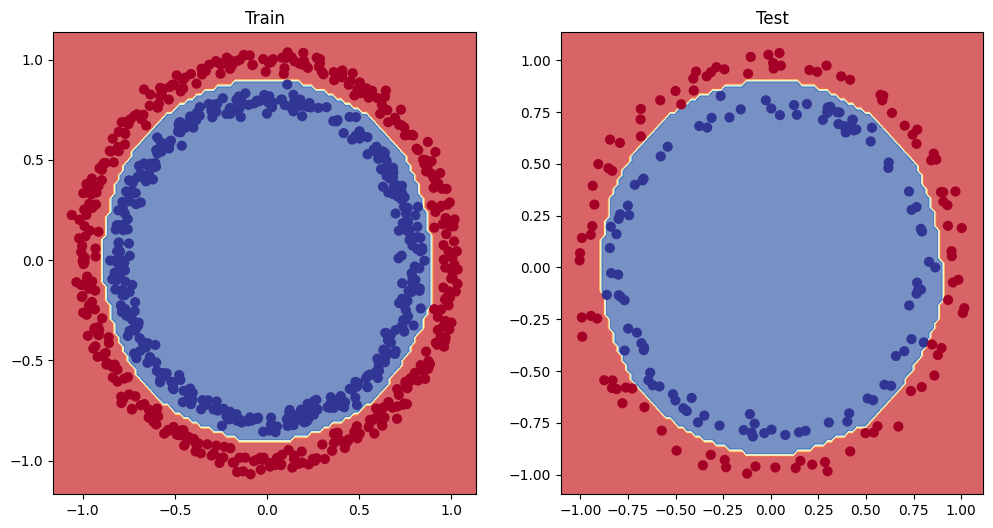

In [ ]:
# Plot decision boundary of the model_1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 8. Putting all together with multiclass clasification

Recall a **binary** classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a **multi-class** classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

### 8.1 Creating a toy mutli-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


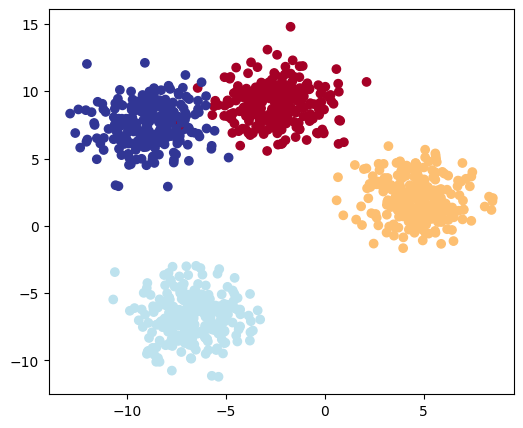

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creatation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(6, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
X_blob.shape, y_blob.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torch import nn
# Build a multi-class clasifictions
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes all required hyperparameters for a multi-class classification model.
        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

### 8.4 Getting prediction probabilities for a multi-class PyTorch model
Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15593, Acc: 48.38% | Test Loss: 0.89213, Test Acc: 70.50%
Epoch: 10 | Loss: 0.14191, Acc: 99.00% | Test Loss: 0.12615, Test Acc: 99.50%
Epoch: 20 | Loss: 0.06998, Acc: 99.00% | Test Loss: 0.06119, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05050, Acc: 99.12% | Test Loss: 0.04207, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04197, Acc: 99.12% | Test Loss: 0.03338, Test Acc: 99.50%
Epoch: 50 | Loss: 0.03732, Acc: 99.12% | Test Loss: 0.02850, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03444, Acc: 99.12% | Test Loss: 0.02540, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03251, Acc: 99.12% | Test Loss: 0.02327, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03115, Acc: 99.12% | Test Loss: 0.02171, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03013, Acc: 99.12% | Test Loss: 0.02052, Test Acc: 99.50%


In [ ]:
# Make predictions
model_4.to(device)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  6.7187,  13.1573, -14.8801,  -9.0285],
        [  2.2134, -15.4788,   1.0266,   8.8693],
        [-10.3632, -16.9811,  21.2564,  12.2752],
        [  3.1689,   9.6254,  -8.2123,  -6.2225],
        [  9.3721,   4.0677, -16.2491,  -4.1638],
        [  2.1848, -19.2145,   2.2230,  11.0924],
        [-10.0643, -12.9433,  19.5422,   9.8188],
        [  7.2617,  -1.0949, -11.3409,  -0.6776],
        [-11.6079, -23.6982,  25.2830,  16.5110],
        [  7.8874,   0.7931, -12.9063,  -1.9233]], device='cuda:0')

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


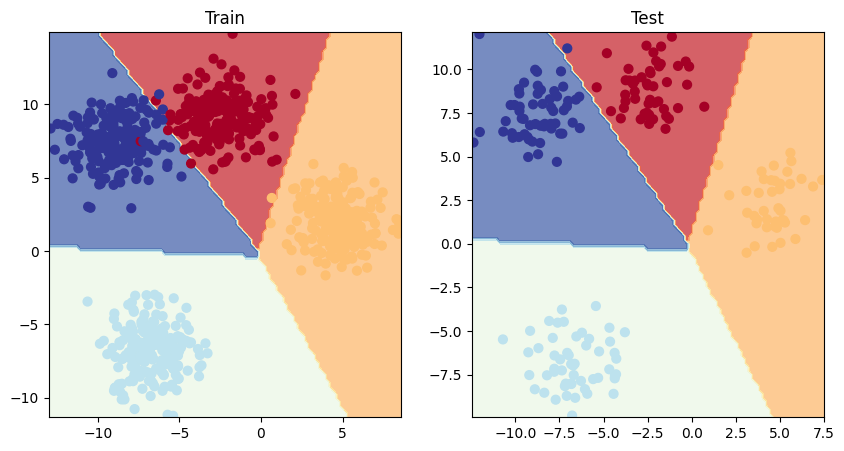

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')